In [1]:
#path
root = '/kaggle/input/iot-modules-singleclass/iot-modules-singleclass'
train, valid, test = root+'/train/', root+'/valid/', root+'/test/'
#library imports
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import cv2, os
import matplotlib.pyplot as plt
import random

In [2]:
def img_preprocessing(path):
        img_data = cv2.imread(path)
        H, W, C = img_data.shape
        # print(H, W, C)
        T, B, L, R = 0, 0, 0, 0 # top bottom left right
        if H > W: # cao hơn rộng => padding chiều rộng
            R = H-W
        elif H < W: #rộng hơn cao => padding chiều cao
            T = W-H
        else: #bang nhau
            pass
        # print(R, T)
        transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Pad(padding=(L, T, R, B), fill=0, padding_mode='constant'), #trái - trên - phải - dưới
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
        img_data_tensor = transform(img_data)
        return img_data_tensor
def get_paths_and_1hotvectors(path):
    file = open(path+'_classes.csv', 'r')
    DATA = file.readlines()
    label_truth = DATA[0].replace('\n', '').split(',')[1:]
    data = []
    for i in DATA[1:]:
        filename = path + i.split(',')[0]
        onehot_vector = [int(j) for j in i.split(',')[1:]]
        data.append([filename, onehot_vector])
    return label_truth, data
# x, y = get_paths_and_1hotvectors(test)
# print(x[16])
# print(x)
# print(y[0][1].index(1))
# print(y[0][0])
# print(y[0][1])
'''
Photoresistor
['7-segment-LED', 'Board-Test-830', 'Buzzer', 'Dust-sensor-GP2Y1014AU-PM2.5', 'Fingerprint-sensor-AS608-XD-65', 'IR-Remote', 'IR-receiver-1838T', 'KIT-Arduino-UNO-R3-ATMEGA16U2', 'KIT-WiFi-NodeMcu-ESP8266-CH340', 'Keypad-4x4-SMD', 'LCD-1602', 'LED', 'Led-Matrix-8x8', 'Module-Bluetooth-HC05', 'Module-Lora-RF433-SX1278-RA-01', 'Module-Matrix-8x32-MAX7219-MT-832-G', 'Photoresistor', 'Potentiometer', 'Realtime-Module-DS1307', 'Temperature-LM35', 'Ultrasonic-Range-Finder-SRF05', 'servo-motor-SG90']
16
/kaggle/input/iot-modules-singleclass/iot-modules-singleclass/test/20240610_130149_jpg.rf.064f93788c00415dff972f5ed4c5db2b.jpg
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
'''
test_ground_truth, test_img_paths_and_1hotvectors = get_paths_and_1hotvectors(test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_19/3662948493.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

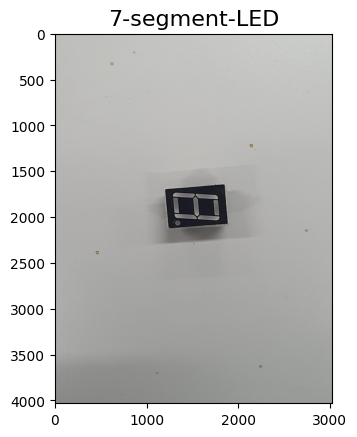

In [3]:
#model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet101(pretrained=False)
for param in model.parameters():
    param.requirse_grad = True
model.fc = torch.nn.Linear(model.fc.in_features, 22)
model = model.to(device)
model.load_state_dict(torch.load('/kaggle/input/22-iot-modules-classification-model/pytorch/default/2/best_model91.pth', map_location=torch.device('cpu')))
model.eval()
img_path = random.choice([i[0] for i in test_img_paths_and_1hotvectors])
img_data = img_preprocessing(img_path).unsqueeze(0) #thêm 1 chiều vào trước C H W => Batch_size C H W
img_data = img_data.to(device)
with torch.no_grad():
    output = model(img_data)
    index = torch.argmax(output, dim=1).item()
    label = test_ground_truth[index]
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title(label, fontsize=16)
plt.show()